In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

In [3]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from torch.utils.data.dataset import Dataset

In [6]:
img_size = 64
n_epochs = 50
batch_size = 64
learning_rate = 0.0001

In [7]:
MODEL_NAME = 'TDCGAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
            ])

In [9]:
fmnist = datasets.FashionMNIST(root='../data/', train=True, transform=transform, download=True)

In [10]:
data_loader = DataLoader(dataset=fmnist, batch_size=batch_size, shuffle=True, drop_last=True)

In [11]:
class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(100, 256*7*7, bias = False),
            nn.BatchNorm1d(256*7*7),
            nn.LeakyReLU(0.3),
        )
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 5, 1, 2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.3),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.3),
            nn.ConvTranspose2d(64, 1, 4, 2, 1),
            nn.Tanh(),
        )
        
    def forward(self, x):
        y = self.layer1(x)
        y = y.view((-1,256,7,7))
        y = self.layer2(y)
        return y

In [12]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(1, 64, 5, 2, 2, bias=True),
            nn.LeakyReLU(0.3),
            nn.Dropout2d(0.3),
            nn.Conv2d(64, 128, 5, 2, 2, bias=True),
            nn.LeakyReLU(0.3),
            nn.Dropout2d(0.3),
        )
        self.linear = nn.Linear(128*7*7,1,bias=True)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):        
        y = self.layer(x)
        y = y.view((-1,128*7*7))
        y = self.linear(y)
        y = self.sigmoid(y)
        return y

In [13]:
class Labeler(nn.Module):
  def __init__(self):
        super(Labeler, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(28*28,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,10)
        )
  def forward(self,x):
    x = x.view(-1,28*28)
    output = self.layer(x)
    return output


In [14]:
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)
L = Labeler().to(DEVICE)

In [15]:
L_opt = torch.optim.Adam(L.parameters(), lr=learning_rate)
crossen = nn.CrossEntropyLoss()
crossen = crossen.to(DEVICE)

In [16]:
from torch.types import Device
L_loss_hist = []
L_acc_hist = []
for epoch in range(n_epochs):
    L_accs = []
    L_losses = []
    for batch, (real_samples,real_labels) in enumerate(data_loader):
        real_samples = real_samples.float().to(DEVICE)
        real_labels = real_labels.long().to(DEVICE)
        
        L.zero_grad()
        yhat = L(real_samples)
        L_loss = crossen(yhat,real_labels)
        predclass = torch.argmax(yhat,dim=1)
        L_acc = torch.mean((predclass==real_labels).float())
        L_loss.backward()
        L_opt.step()
        L_accs.append(L_acc)
        L_losses.append(L_loss)
    if ((epoch+1)%10==0):
        print(f"Epoch: {epoch+1} Label Accuracy: {torch.mean(torch.FloatTensor(L_accs))} Label Loss: {torch.mean(torch.FloatTensor(L_losses))}")
    L_loss_hist.append(torch.mean(torch.FloatTensor(L_losses)))
    L_acc_hist.append(torch.mean(torch.FloatTensor(L_accs)))

Epoch: 10 Label Accuracy: 0.8856890201568604 Label Loss: 0.31475719809532166
Epoch: 20 Label Accuracy: 0.9104188680648804 Label Loss: 0.24513661861419678
Epoch: 30 Label Accuracy: 0.929845929145813 Label Loss: 0.19548949599266052
Epoch: 40 Label Accuracy: 0.9444870352745056 Label Loss: 0.15501099824905396
Epoch: 50 Label Accuracy: 0.9573939442634583 Label Loss: 0.12046295404434204


In [17]:
target_ones = torch.ones((batch_size, 1), device=DEVICE)
target_zeros = torch.zeros((batch_size, 1), device=DEVICE)
target_nines = []
for i in range(batch_size):
  target_nines.append(9)
target_nines = torch.Tensor(target_nines).to(DEVICE)

In [18]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=learning_rate, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=learning_rate, betas=(0.5, 0.999))

In [19]:
def generate_samples(G,latent_v):
  with torch.no_grad():
    samples = G(latent_v)
  samples = samples.cpu()
  images = torchvision.utils.make_grid(samples,normalize=True)
  plt.imshow(images.numpy().transpose((1,2,0)))
  plt.show()

Epoch 1 Discriminator Loss: 0.392, Generator Loss: 0.831
Epoch 2 Discriminator Loss: 0.371, Generator Loss: 0.824
Epoch 3 Discriminator Loss: 0.325, Generator Loss: 0.910
Epoch 4 Discriminator Loss: 0.314, Generator Loss: 0.948
Epoch 5 Discriminator Loss: 0.315, Generator Loss: 0.962
Epoch 6 Discriminator Loss: 0.319, Generator Loss: 0.961
Epoch 7 Discriminator Loss: 0.320, Generator Loss: 0.969
Epoch 8 Discriminator Loss: 0.321, Generator Loss: 0.971
Epoch 9 Discriminator Loss: 0.319, Generator Loss: 0.978
Epoch 10 Discriminator Loss: 0.318, Generator Loss: 0.978


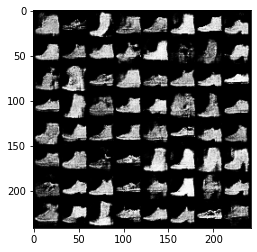

Epoch 11 Discriminator Loss: 0.318, Generator Loss: 0.984
Epoch 12 Discriminator Loss: 0.315, Generator Loss: 0.990
Epoch 13 Discriminator Loss: 0.314, Generator Loss: 0.993
Epoch 14 Discriminator Loss: 0.311, Generator Loss: 0.998
Epoch 15 Discriminator Loss: 0.310, Generator Loss: 1.001
Epoch 16 Discriminator Loss: 0.309, Generator Loss: 1.004
Epoch 17 Discriminator Loss: 0.307, Generator Loss: 1.009
Epoch 18 Discriminator Loss: 0.307, Generator Loss: 1.014
Epoch 19 Discriminator Loss: 0.306, Generator Loss: 1.016
Epoch 20 Discriminator Loss: 0.306, Generator Loss: 1.019
Epoch 21 Discriminator Loss: 0.304, Generator Loss: 1.020
Epoch 22 Discriminator Loss: 0.303, Generator Loss: 1.021
Epoch 23 Discriminator Loss: 0.303, Generator Loss: 1.025
Epoch 24 Discriminator Loss: 0.302, Generator Loss: 1.027
Epoch 25 Discriminator Loss: 0.301, Generator Loss: 1.031
Epoch 26 Discriminator Loss: 0.303, Generator Loss: 1.025
Epoch 27 Discriminator Loss: 0.300, Generator Loss: 1.030
Epoch 28 Discr

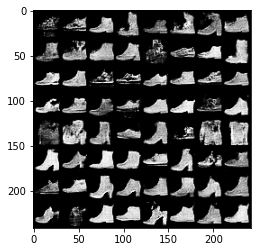

Epoch 31 Discriminator Loss: 0.300, Generator Loss: 1.034
Epoch 32 Discriminator Loss: 0.299, Generator Loss: 1.031
Epoch 33 Discriminator Loss: 0.297, Generator Loss: 1.041
Epoch 34 Discriminator Loss: 0.296, Generator Loss: 1.040
Epoch 35 Discriminator Loss: 0.298, Generator Loss: 1.040
Epoch 36 Discriminator Loss: 0.295, Generator Loss: 1.037
Epoch 37 Discriminator Loss: 0.295, Generator Loss: 1.037
Epoch 38 Discriminator Loss: 0.295, Generator Loss: 1.041
Epoch 39 Discriminator Loss: 0.295, Generator Loss: 1.042
Epoch 40 Discriminator Loss: 0.294, Generator Loss: 1.046
Epoch 41 Discriminator Loss: 0.296, Generator Loss: 1.043
Epoch 42 Discriminator Loss: 0.294, Generator Loss: 1.046
Epoch 43 Discriminator Loss: 0.294, Generator Loss: 1.047
Epoch 44 Discriminator Loss: 0.294, Generator Loss: 1.044
Epoch 45 Discriminator Loss: 0.292, Generator Loss: 1.050
Epoch 46 Discriminator Loss: 0.293, Generator Loss: 1.050
Epoch 47 Discriminator Loss: 0.293, Generator Loss: 1.047
Epoch 48 Discr

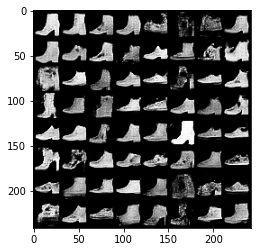

In [20]:
D_loss_hist = []
G_loss_hist = []
noise = lambda x: torch.randn((x,100), device = DEVICE)
for epoch in range(n_epochs):

  D_losses = []
  G_losses = []
  
  for batch, (images,labels) in enumerate(data_loader):
    real_samples = images.to(DEVICE)
    latent_v = noise(batch_size)
    #Train Discriminator
    D.zero_grad()
    pred_real = D(real_samples)
    loss_real = criterion(pred_real,target_ones)
    with torch.no_grad():
      fake_samples = G(latent_v)
    pred_fake = D(fake_samples)
    loss_fake = criterion(pred_fake,target_zeros)
    loss = (loss_real+loss_fake)/2
    loss.backward()
    D_opt.step()
    D_losses.append(loss)
    
    #Train Generator
    G.zero_grad()
    generated = G(latent_v)
    classes = D(generated)
    gen_loss1 = criterion(classes, target_ones)
    targets = L(generated)
    gen_loss9 = crossen(targets, target_nines.long())
    gen_loss = (gen_loss1+gen_loss9)/2
    gen_loss.backward()
    G_opt.step()
    G_losses.append(gen_loss)

    
  print('Epoch {} Discriminator Loss: {:.3f}, Generator Loss: {:.3f}'.format((epoch + 1),
                                                           torch.mean(torch.FloatTensor(D_losses)),
                                                           torch.mean(torch.FloatTensor(G_losses))))
  if(epoch == 9 or epoch == 29 or epoch == 49):
    generate_samples(G,latent_v)
  D_loss_hist.append(torch.mean(torch.FloatTensor(D_losses)))
  G_loss_hist.append(torch.mean(torch.FloatTensor(G_losses)))

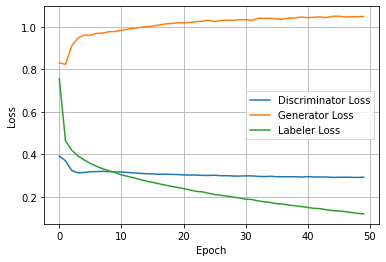

In [21]:
plt.plot(range(50),D_loss_hist,label='Discriminator Loss')
plt.plot(range(50),G_loss_hist,label='Generator Loss')
plt.plot(range(50),L_loss_hist,label='Labeler Loss')
plt.plot(range(50),L_acc_hist,label='Labeler Accuracy')
plt.legend()
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

As we can see, the generator's loss is approximately the inverse of the other two networks' losses

tensor([9, 9, 9, 9, 9], device='cuda:0')


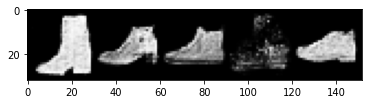

tensor([9, 9, 9, 9, 9], device='cuda:0')


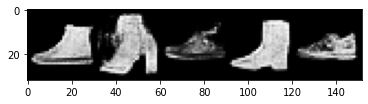

tensor([9, 9, 9, 9, 9], device='cuda:0')


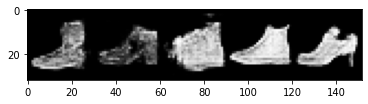

tensor([9, 9, 9, 9, 9], device='cuda:0')


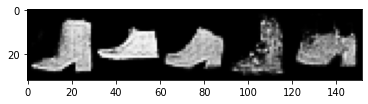

tensor([9, 9, 9, 9, 9], device='cuda:0')


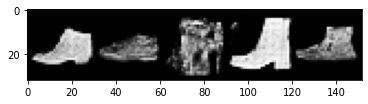

In [25]:
for i in range(5):
  latent_test = noise(5)
  with torch.no_grad():
      samples = G(latent_test)
      labels = L(samples)
  sample = samples.cpu()
  print(torch.argmax(labels,dim=1))
  images = torchvision.utils.make_grid(sample,normalize=True)
  plt.imshow(images.numpy().transpose((1,2,0)))
  plt.show()

For reference:

    0: T-shirt/top
    1: Trouser
    2: Pullover
    3: Dress
    4: Coat
    5: Sandal
    6: Shirt
    7: Sneaker
    8: Bag
    9: Ankle boot
As we can see, the final network makes nothing but ankle boots, exactly as intended!